1. Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os
dados estão corretos e realizar algum procedimento necessário caso haja dados
faltantes.

In [1]:
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [25,6]
plt.rc('font', size=14) # Altera o tamanho da fonte

%matplotlib inline

In [2]:
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True)

idx = pd.date_range(start=covid.index.min(), end=covid.index.max(), freq='D')
covid = covid.reindex(idx)
covid.fillna(0, inplace=True)


covid.head()

,confirmed,deaths
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


- dia 20/03/20
> - está como 0 em deaths<br>
> - nos dias anteriores estão completos<br>
> - tem que ajustar esse valor <br>

INCLUIDO 1 NO DIA 20/03 E REMOVIDO 1 DO DIA 19/03



In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2020-01-01 to 2020-09-03
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   confirmed  247 non-null    int64
 1   deaths     247 non-null    int64
dtypes: int64(2)
memory usage: 5.8 KB


In [4]:
covid.describe()

,confirmed,deaths
count,247.000000,247.000000
mean,24754.680162,752.000000
std,21935.393529,768.724717
min,0.000000,0.000000
25%,19.500000,1.000000
50%,23705.000000,661.000000
75%,41252.500000,1180.500000
max,78427.000000,4928.000000


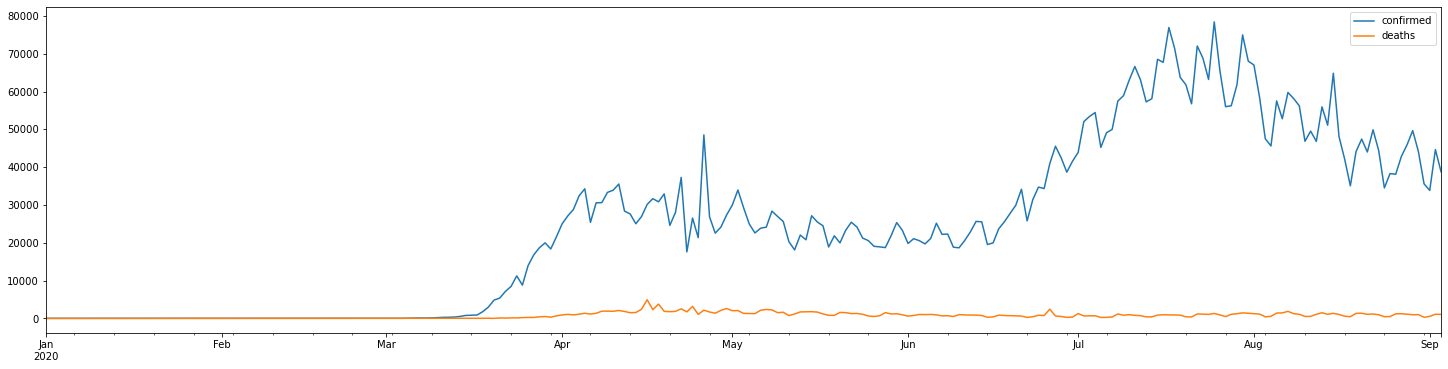

In [5]:
covid.plot(figsize=(25,6));

2. Proponha uma decomposição dos dados de mortes em tendência e sazonalidade.
Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente
brevemente os resultados.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

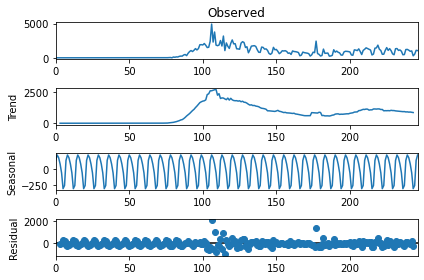

In [7]:

mortes = np.array(list(covid.deaths))

result = seasonal_decompose(mortes, model='additive', period=7)
result.plot()

plt.show()

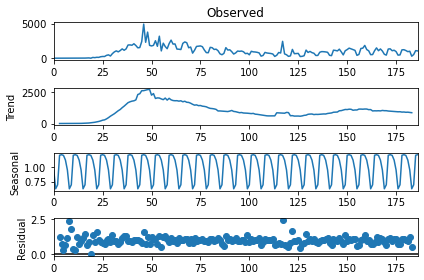

In [8]:
mortes_mult = np.array(list(covid.deaths[covid.deaths > 0]))

result = seasonal_decompose(mortes_mult, model='multiplicative', period=7)
result.plot()

plt.show()

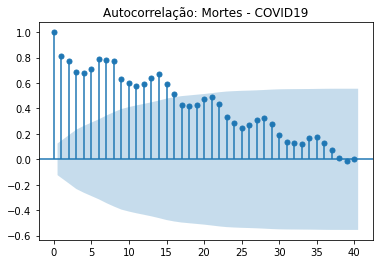

In [9]:
title = 'Autocorrelação: Mortes - COVID19'
lags = 40
plot_acf(covid.deaths, title=title,lags=lags);

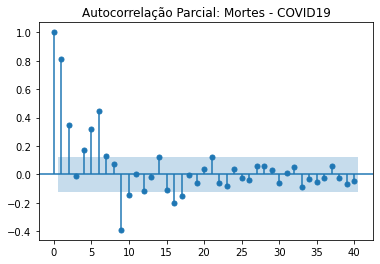

In [10]:
title = 'Autocorrelação Parcial: Mortes - COVID19'
lags = 40
plot_pacf(covid.deaths, title=title,lags=lags);

3. Divida a base em treino e teste, com 21 observações na base de teste. Você deverá
apresentar em distintas colunas na mesma base de dados que será entregue:
- Os dados originais de casos confirmados e mortes.
- As previsões de Holt e Holt Winters para a variável mortes.
- As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas
segundo critério preestabelecido para a variável mortes. Identifique as
componentes desse melhor modelo (por exemplo, “o modelo tem uma
componente autorregressiva não sazonal de ordem .., uma componente de
médias móveis não-sazonal de ordem.., etc).
- As previsões obtidas por um modelo de redes dinâmicas para a variável
mortes.

In [11]:
treino = covid.iloc[:226]
teste = covid.iloc[226:]

In [12]:
# Método de Holt 

from statsmodels.tsa.api import ExponentialSmoothing

modelo =  ExponentialSmoothing(treino.deaths, trend='add').fit();

treino['Holt'] = modelo.fittedvalues.shift(-1);
treino.head()

,confirmed,deaths,Holt
2020-01-01,0,0,8.383961
2020-01-02,0,0,10.737142
2020-01-03,0,0,12.356779
2020-01-04,0,0,13.471380
2020-01-05,0,0,14.238271


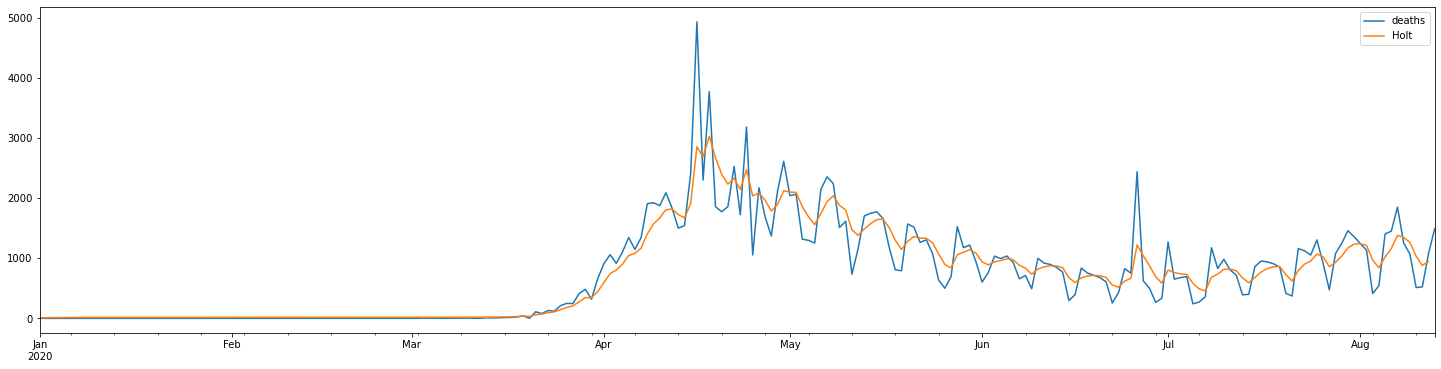

In [13]:
treino[['deaths','Holt']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [14]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade aditiva

modelo =  ExponentialSmoothing(treino.deaths,trend='add',seasonal='add',seasonal_periods=7).fit()

treino['Holt-Winters-adit-7'] = modelo.fittedvalues

treino.head()

,confirmed,deaths,Holt,Holt-Winters-adit-7
2020-01-01,0,0,8.383961,4.826571
2020-01-02,0,0,10.737142,8.178389
2020-01-03,0,0,12.356779,10.468224
2020-01-04,0,0,13.471380,12.164478
2020-01-05,0,0,14.238271,13.367570


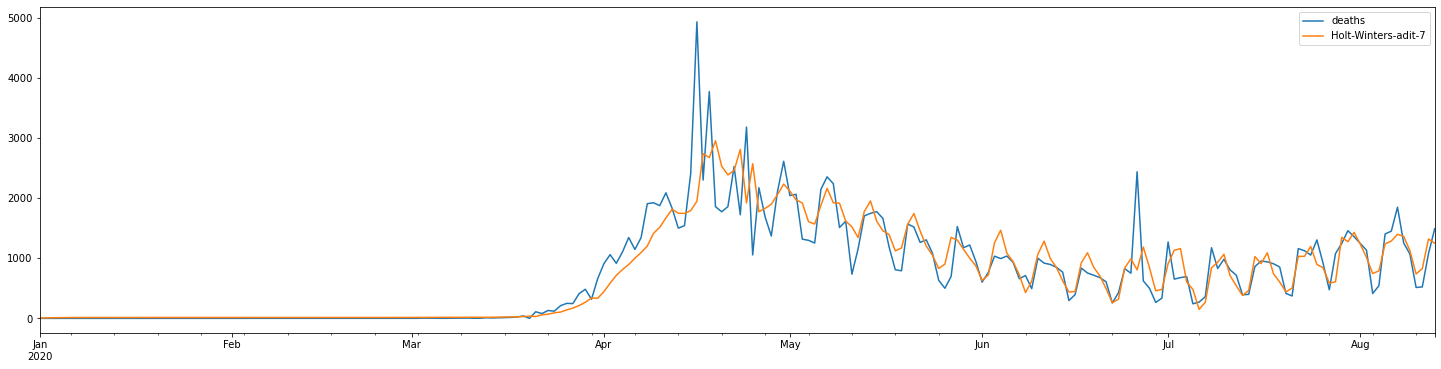

In [15]:
treino[['deaths','Holt-Winters-adit-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [16]:
# Base de Treinamento para métodos multiplicativos
treino_mult = covid.iloc[:226]
teste_mult = covid.iloc[226:]

treino_mult = treino_mult[treino_mult.deaths > 0]
teste_mult = teste_mult[teste_mult.deaths > 0]

In [17]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade multiplicativa

modelo =  ExponentialSmoothing(treino_mult.deaths,trend='add',seasonal='mul',seasonal_periods=7).fit()

treino_mult['Holt-Winters-mult-7'] = modelo.fittedvalues

treino_mult.head()

/home/guilo/anaconda3/envs/dinamica/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,confirmed,deaths,Holt-Winters-mult-7
2020-03-01,3,1,1.000435
2020-03-02,20,1,1.000760
2020-03-03,14,4,4.004014
2020-03-04,22,3,3.003556
2020-03-05,34,2,2.002642


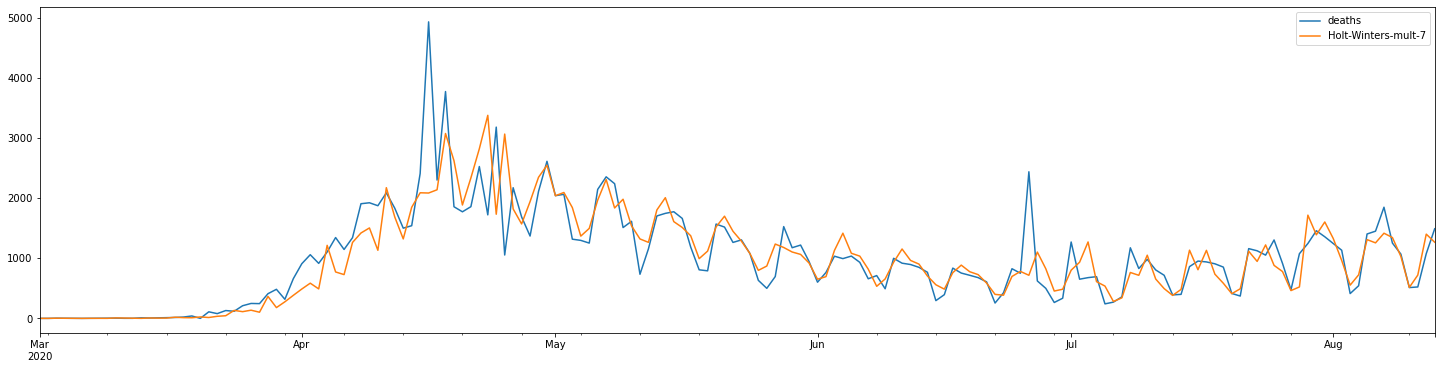

In [18]:
treino_mult[['deaths','Holt-Winters-mult-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima                              

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pmdarima'

In [20]:

# auto_arima(covid.deaths,seasonal=True,m=7).summary()

# stepwise_fit = auto_arima(covid.deaths, start_p=0, start_q=0,
#                           max_p=6, max_q=3, m=7,
#                           seasonal=True,
#                           trace=True,
#                           error_action='ignore',   
#                           suppress_warnings=True,  
#                           stepwise=True)           

# stepwise_fit.summary()

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
treino = treino.drop(['confirmed', 'Holt', 'Holt-Winters-adit-7'], axis=1)
teste = teste.drop('confirmed', axis=1)

In [24]:
treino

,deaths
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-08-09,1069
2020-08-10,513
2020-08-11,523
2020-08-12,1076


In [25]:

scaler.fit(treino)

MinMaxScaler()

In [26]:
scaled_train = scaler.transform(treino)
scaled_test = scaler.transform(teste)

In [27]:
print(scaled_train.min(),scaled_train.max())

0.0 1.0


In [28]:
print(scaled_test.min(),scaled_test.max())

0.0588474025974026 0.27516233766233766


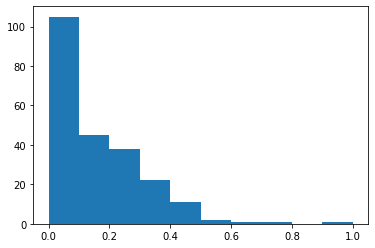

In [29]:
plt.hist(scaled_train);

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [31]:
# defina o gerador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [32]:
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [34]:
# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit_generator(generator,epochs=100)


Epoch 1/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0140
Epoch 2/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 3/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0079
Epoch 4/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 5/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0083
Epoch 6/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 7/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 8/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0072
Epoch 9/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 10/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0077
Epoch 11/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0075
Epoch 12/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 13/1

In [37]:
model.history.history.keys()

dict_keys(['loss'])

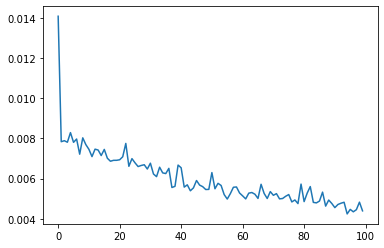

In [38]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [39]:
first_eval_batch = scaled_train[-7:]

In [40]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [41]:
model.predict(first_eval_batch)

array([[0.27447802]], dtype=float32)

In [42]:
scaled_test[0]

array([0.21976461])

In [43]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [44]:
current_batch.shape

(1, 7, 1)

In [45]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.25405844],
        [ 0.2169237 ],
        [ 0.10409903],
        [ 0.10612825],
        [ 0.21834416],
        [ 0.3023539 ],
        [99.        ]]])

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(teste)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

In [50]:
teste['Predictions'] = true_predictions

In [51]:
teste

,deaths,Predictions
2020-08-14,1083,1352.627674
2020-08-15,1336,1195.812403
2020-08-16,1035,953.189146
2020-08-17,571,640.961392
2020-08-18,445,489.175505
2020-08-19,1324,778.996561
2020-08-20,1356,1005.947837
2020-08-21,1078,1063.196510
2020-08-22,1151,1041.769444
2020-08-23,956,916.365106


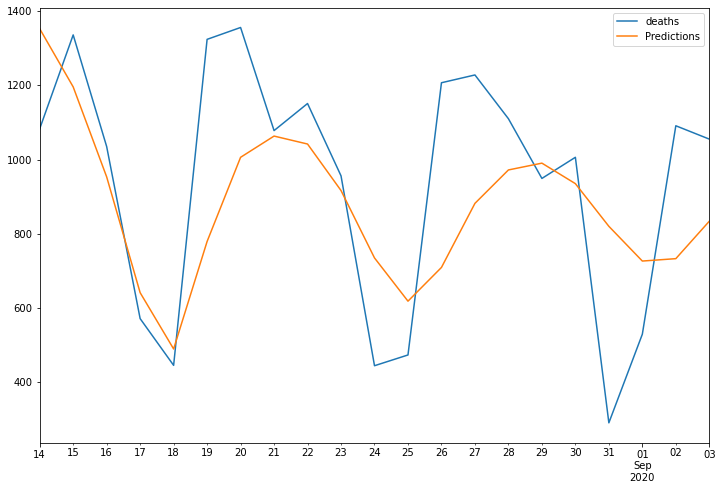

In [53]:
teste.plot(figsize=(12,8));

In [54]:
model.save('my_rnn_model.h5')